# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [4]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 KB 8.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 42.2 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [7]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 16.6 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 33.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 677.9 kB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [1]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [3]:
client = MongoClient(mongod_connect)
db = client.demo # use or create a database named demo
tweet_collection = db.tweet_Lab9 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['covid19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [15]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [6]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [7]:
count = 100 #number of returned tweets, default and max is 100
#geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [8]:
search_results = rest_api.search.tweets( count=count,q=q) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Wed Nov 09 20:34:58 +0000 2022'
'Wed Nov 09 20:34:57 +0000 2022'
'Wed Nov 09 20:34:53 +0000 2022'
'Wed Nov 09 20:34:49 +0000 2022'
'Wed Nov 09 20:34:48 +0000 2022'
'Wed Nov 09 20:34:47 +0000 2022'
'Wed Nov 09 20:34:45 +0000 2022'
'Wed Nov 09 20:34:45 +0000 2022'
'Wed Nov 09 20:34:42 +0000 2022'
'Wed Nov 09 20:34:39 +0000 2022'
'Wed Nov 09 20:34:35 +0000 2022'
'Wed Nov 09 20:34:35 +0000 2022'
'Wed Nov 09 20:34:29 +0000 2022'
'Wed Nov 09 20:34:24 +0000 2022'
'Wed Nov 09 20:34:24 +0000 2022'
'Wed Nov 09 20:34:24 +0000 2022'
'Wed Nov 09 20:34:22 +0000 2022'
'Wed Nov 09 20:34:21 +0000 2022'
'Wed Nov 09 20:34:20 +0000 2022'
'Wed Nov 09 20:34:19 +0000 2022'
'Wed Nov 09 20:34:19 +0000 2022'
'Wed Nov 09 20:34:17 +0000 2022'
'Wed Nov 09 20:34:11 +0000 2022'
'Wed Nov 09 20:34:10 +0000 2022'
'Wed Nov 09 20:33:59 +0000 2022'
'Wed Nov 09 20:33:59 +0000 2022'
'Wed Nov 09 20:33:59 +0000 2022'
'Wed Nov 09 20:33:54 +0000 2022'
'Wed Nov 09 20:33:54 +0000 2022'
'Wed Nov 09 20:33:52 +0000 2022'
'Wed Nov 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [19]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                         max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Nov 09 18:00:01 +0000 2022'
'Wed Nov 09 17:44:43 +0000 2022'
'Wed Nov 09 17:43:02 +0000 2022'
'Wed Nov 09 17:12:38 +0000 2022'
'Wed Nov 09 17:06:17 +0000 2022'
'Wed Nov 09 15:41:43 +0000 2022'
'Wed Nov 09 15:27:09 +0000 2022'
'Wed Nov 09 14:48:22 +0000 2022'
'Wed Nov 09 14:13:02 +0000 2022'
'Wed Nov 09 12:53:48 +0000 2022'
'Wed Nov 09 12:51:08 +0000 2022'
'Wed Nov 09 09:50:13 +0000 2022'
'Wed Nov 09 08:05:30 +0000 2022'
'Wed Nov 09 08:05:30 +0000 2022'
'Wed Nov 09 08:05:29 +0000 2022'
'Wed Nov 09 08:05:27 +0000 2022'
'Wed Nov 09 08:05:25 +0000 2022'
'Wed Nov 09 08:05:24 +0000 2022'
'Wed Nov 09 08:05:22 +0000 2022'
'Wed Nov 09 08:05:20 +0000 2022'
'Wed Nov 09 08:05:18 +0000 2022'
'Wed Nov 09 08:05:18 +0000 2022'
'Wed Nov 09 08:05:17 +0000 2022'
'Wed Nov 09 08:05:17 +0000 2022'
'Wed Nov 09 08:05:15 +0000 2022'
'Wed Nov 09 08:05:09 +0000 2022'
'Wed Nov 09 08:05:08 +0000 2022'
'Wed Nov 09 08:05:00 +0000 2022'
'Wed Nov 09 08:04:58 +0000 2022'
'Wed Nov 09 08:04:56 +0000 2022'
'Wed Nov 0

TwitterHTTPError: Twitter sent status 429 for URL: 1.1/search/tweets.json using parameters: (count=100&max_id=1590242942069145601&oauth_consumer_key=i4g6pTDMtGTTTk232Ft5NH1Ed&oauth_nonce=14303853149860876722&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1668027594&oauth_token=60388598-mylObKICmdarCkLD84rx8vtJqzz08te0LBNb1VFsl&oauth_version=1.0&q=covid19&oauth_signature=DJZMbY563cILBDnyyowY9ouEPXQ%3D)
details: {'errors': [{'message': 'Rate limit exceeded', 'code': 88}]}

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [9]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

18322
13560


Create a text index and print the Tweets containing specific keywords. 

In [10]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [11]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pprint to display tweets

In [12]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: unlixGhost.eth
text: And we still have the issues of #COVID19, Wuhan, Russian Pre-Text War, BRICS, and the 2024 Election.
----
name: Adrian (Pro Constitutional Republic) Slade ❌
text: Just like the Covid19 lockdowns, Ron DeSantis will lead the way to election integrity. #RonDeSantis
----
name: Mighty Joe Young #BuildBackBetter #BlueWave2022
text: RT @jayoung1892: Congratulations @GovNedLamont @NedLamont on winning re-election last night. The greatest #Governor in the nation, when it…
----
name: LastKingofScotland
text: @Nigel_Farage US elections are negotiations. A lot of lawfare during and after. We have the technology to count vot… https://t.co/snwrB3yHK0
----
name: Maria
text: RT @BlueRoomStream: Candidate for Governor @DarrenBaileyIL: Recently, "while running for re-election, JB said he would not mandate the #COV…
----
name: Marni Karlin
text: Now that the election is over, maybe the Administration can acknowledge we're still in the middle of the #COVID19… https://t.co/S

In [17]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pandas to display tweets

In [18]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive
0,636bf4b58f3f60c31b5ead91,Wed Nov 09 13:02:00 +0000 2022,1590328854488698880,1590328854488698880,"And we still have the issues of #COVID19, Wuha...",False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.590328e+18,...,0,1,False,False,en,NaN,NaN,NaN,NaN,NaN
1,636bf4448f3f60c31b5e9a16,Wed Nov 09 16:10:58 +0000 2022,1590376409859780610,1590376409859780610,"Just like the Covid19 lockdowns, Ron DeSantis ...",False,"{'hashtags': [{'text': 'RonDeSantis', 'indices...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,3,False,False,en,NaN,NaN,NaN,NaN,NaN
2,636bfc49bb7c8aa340344d84,Wed Nov 09 18:50:28 +0000 2022,1590416549797842945,1590416549797842945,RT @jayoung1892: Congratulations @GovNedLamont...,False,"{'hashtags': [{'text': 'Governor', 'indices': ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1,0,False,False,en,{'created_at': 'Wed Nov 09 13:47:25 +0000 2022...,NaN,NaN,NaN,NaN
3,636bf55a8f3f60c31b5ec7eb,Wed Nov 09 08:14:00 +0000 2022,1590256375707623425,1590256375707623425,@Nigel_Farage US elections are negotiations. A...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.590252e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,636bf4f58f3f60c31b5eb885,Wed Nov 09 10:58:00 +0000 2022,1590297649244418048,1590297649244418048,RT @BlueRoomStream: Candidate for Governor @Da...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,196,0,False,False,en,{'created_at': 'Mon Nov 07 17:40:54 +0000 2022...,NaN,NaN,NaN,NaN
5,636bf4308f3f60c31b5e970c,Wed Nov 09 16:36:42 +0000 2022,1590382887769354240,1590382887769354240,"Now that the election is over, maybe the Admin...",True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
6,636bf4278f3f60c31b5e95b7,Wed Nov 09 16:50:51 +0000 2022,1590386447496138752,1590386447496138752,RT @BlueRoomStream: Candidate for Governor @Da...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,196,0,False,False,en,{'created_at': 'Mon Nov 07 17:40:54 +0000 2022...,NaN,NaN,NaN,NaN
7,636bf43f8f3f60c31b5e9985,Wed Nov 09 16:17:28 +0000 2022,1590378044317138944,1590378044317138944,RT @adriansladeshow: Just like the Covid19 loc...,False,"{'hashtags': [{'text': 'RonDeSantis', 'indices...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,0,False,False,en,{'created_at': 'Wed Nov 09 16:10:58 +0000 2022...,NaN,NaN,NaN,NaN
8,636c0ebfcdaa0abc7cfccc3d,Wed Nov 09 19:28:40 +0000 2022,1590426162916118529,1590426162916118529,@AnnieAndrewsMD @NancyMace is one of those pec...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.590424e+18,...,0,4,False,False,en,NaN,NaN,NaN,NaN,NaN
9,636c0ea9cdaa0abc7cfcc85c,Wed Nov 09 20:12:34 +0000 2022,1590437209391632384,1590437209391632384,@Mon4Kooyong Funny that covid19 is not a “thin...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.5

<AxesSubplot:>

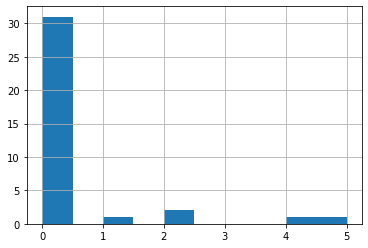

In [15]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count